# Working with Spectra

This tutorial expands upon [01_QuickStart.ipynb](01_QuickStart.ipynb) and [03_DataOrganization.ipynb](03_DataOrganization.ipynb) to provide
more details about working with DESI spectra, including software tools for reading and
manipulating the DESI spectra format.  Some information is repeated, to help this tutorial
be stand-alone.

Topics covered here
  * Directory structure and file formats
  * Tools for reading, slicing, combining, and writing spectra data
  * Working with spectra efficiently (memory and I/O)
  * Coadding spectra across cameras

## Imports

In [1]:
import os

import numpy as np
import scipy.sparse
import fitsio
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from desitarget.targetmask import desi_mask
import desispec.io
import desispec.spectra
import desispec.resolution
from desispec.coaddition import coadd_cameras

In [2]:
# Determine data location under $DESI_ROOT/spectro/redux/iron
specprod = 'iron'    # Primary spectroscopic production in DR1
desi_root = os.environ['DESI_ROOT']
specprod_dir = f'{desi_root}/spectro/redux/{specprod}'
print(specprod_dir)

/Users/sbailey/desi/tiny_dr1//spectro/redux/iron


## Review of directory structure and available files

As a reminder from [03_DataOrganization.ipynb](03_DataOrganization.ipynb), the spectra are available in two forms:

* **tile-based spectra** which coadd exposures of the same tiles, but do not coadd across tiles even if the same targets were reobserved.
* **healpix-based spectra** which combine all data for a given survey/program on a given healpix on the sky, including coadding exposures across tiles.  

**Most analyses should use healpix-based spectra**, so we will focus on that for this tutorial.

Healpix-based spectra are under `spectro/redux/iron/healpix/SURVEY/PROGRAM/HPIXGROUP/HEALPIX/`, where
  * `SURVEY` is the DESI phase of the survey (e.g. sv1, sv3, main)
  * `PROGRAM` is the sub-survey program observing conditions (e.g. dark, bright)
  * `HEALPIX` is the nside=64 nested-scheme healpix number
  * `HPIXGROUP=int(HEALPIX/100)` (just to avoid thousands of healpix directories at the same level)

nside=64 healpix have an area of ~0.84 deg$^2$ (compared to the ~8 deg$^2$ covered by the DESI focal plane).
Depending upon how the tile observations overlap a given healpix, the healpix directories can have anywhere
from a few to many thousands of targets.

Let's look at one healpix directory included in the "tiny_dr1" subset.

In [3]:
survey = 'main'
program = 'dark'
healpix = 23040
hpix_group = healpix//100

hpixdir = f'{specprod_dir}/healpix/{survey}/{program}/{hpix_group}/{healpix}'
os.listdir(hpixdir)

['coadd-main-dark-23040.fits',
 'hpixexp-main-dark-23040.csv',
 'emline-main-dark-23040.fits',
 'spectra-main-dark-23040.fits.gz',
 'qso_mgii-main-dark-23040.fits',
 'redux_iron_healpix_main_dark_230_23040.sha256sum',
 'qso_qn-main-dark-23040.fits',
 'redrock-main-dark-23040.fits',
 'rrdetails-main-dark-23040.h5']

These filenames follow the form `PREFIX-SURVEY-PROGRAM-HEALPIX.*` where the various `PREFIX`es are:

* **spectra**: uncoadded spectra
* **coadd**: coadded spectra combining information across multiple exposures
* **redrock**: redshift fits and spectral classification
* **rrdetails**: detailed Redrock information, e.g. second best fits
* **emline**: simple Gaussian fits to emission lines based upon their expected location given the redshift
* **qso_qn**: QuasarNet output (fit to all targets, not just those targeted as QSOs or identified by Redrock as QSOs)
* **qso_mgii**: [MgII] fits (like qso_qn, this is run on all targets)
* **zmtl**: information used for updating the "Merged Target List" for operations


## coadd and spectra file formats

Let's explore the format of the spectra*.fits.gz and coadd*.fits.gz files.

In [4]:
specfile = f'{hpixdir}/spectra-{survey}-{program}-{healpix}.fits.gz'
coaddfile = f'{hpixdir}/coadd-{survey}-{program}-{healpix}.fits'

print(f'----- {os.path.basename(specfile)} format -----')
with fits.open(specfile) as fp:
    fp.info()

print(f'\n----- {os.path.basename(coaddfile)} format -----')
with fits.open(coaddfile) as fp:
    print(fp.info())

----- spectra-main-dark-23040.fits.gz format -----
Filename: /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/healpix/main/dark/230/23040/spectra-main-dark-23040.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   ()      
  1  FIBERMAP      1 BinTableHDU    209   1917R x 75C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, K, D, D, D, D, D, D, D, D, J, J, D, J]   
  2  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  3  B_FLUX        1 ImageHDU        11   (2751, 1917)   float32   
  4  B_IVAR        1 ImageHDU        11   (2751, 1917)   float32   
  5  B_MASK        1 ImageHDU        10   (2751, 1917)   int32   
  6  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 1917)   float32   
  7  R_WAVELENGTH    1 ImageHDU        10   (2326,)   float64   
  8  R_FLUX        1 

### Format similarities

Both spectra and coadd files have the following HDUs (as a review from [01_QuickStart.ipynb](01_QuickStart.ipynb)):

* **FIBERMAP** Table of information about the different targets
* For every camera (**B**, **R**, **Z**), we have
  * **WAVELENGTH**: the 1D wavelength array for all spectra on that camera (Angstroms)
  * **FLUX**: 2D[nspec,nwave] spectral flux (10^-17 erg/s/cm2/Angstrom)
  * **IVAR**: 2D[nspec,nwave] inverse variance of FLUX
  * **RESOLUTION**: diagonals of a matrix defining the per-fiber wavelength-dependent instrument resolution
* **SCORES** Table of quality scores measures from the spectra

**NOTE**: The `fp.info()` printed above lists the dimensions in FITS-order, which is reversed when read as a numpy array.
e.g. `B_FLUX` is listed with dimensions `(2751, 1323)` above, but reading it in produces

In [5]:
with fits.open(coaddfile) as fp:
    print(f"B_FLUX.shape={fp['B_FLUX'].data.shape}")

B_FLUX.shape=(1323, 2751)


i.e. this is 1323 rows of spectra, with 2751 wavelengths each (matching the length of the 1D `B_WAVELENGTH` array).

### Format differences

We can see that the two files have mostly the same format except
* `coadd` has one additional HDU `EXP_FIBERMAP`
* The `FIBERMAP` HDU has a different number of columns
* `spectra` HDUs have more rows (1917) compared to `coadd` (1323)
* `spectra` files are gzipped, but `coadd` files are not (for faster access)

spectra files have all of the uncoadded spectra, with one entry per target per exposure,
while the coadd files have spectra coadded across exposures, with one entry per target.

The spectra `FIBERMAP` is a table containing info about the target spectra, e.g. their
`TARGETID`, `TARGET_RA`, `TARGET_DEC`, and the `TILEID` and `FIBER` to which they were
assigned when observed on a given `NIGHT` and exposure ID `EXPID`.

Some, but not all of those targets received multiple observations across multiple tiles.
When coadded, some quantities like `TARGETID`, `TARGET_RA`, and `TARGET_DEC` remain unchanged
and are included in the coadd `FIBERMAP` HDU.  Other columns can be meaningfully averaged
or summed (like the exposure time `EXPTIME`), while others only apply to individual exposures
(like `TILEID`, `FIBER`) and thus are kept in a separate uncoadded `EXP_FIBERMAP`.

**Most analyses can use the data in the coadd files**.  The uncoadded spectra files are provided
for analyses that need to study time variability or are checking for issues that might arise
from individual exposures that would be less obvious in the coadd.

## Reading coadd and spectra files

In [01_QuickStart.ipynb](01_QuickStart.ipynb), we showed how to read the coadd files using [fitsio](https://github.com/esheldon/fitsio),
without requiring any DESI-specific code.
The [desispec](https://github.com/desihub/desispec) package provides wrapper functions and objects
to simplify working with this format, in particular
  * `desispec.io.read_spectra`
  * `desispec.spectra.Spectra` (returned by `read_spectra`)
  * `desispec.spectra.stack`
  * `desispec.io.write_spectra`

### Reading spectra with `desispec.io.read_spectra`

`desispec.io.read_spectra` can be used to read either coadd or spectra files.  Here we'll read the coadd file.

In [6]:
coadd = desispec.io.read_spectra(coaddfile)

INFO:spectra.py:391:read_spectra: iotime 0.312 sec to read coadd-main-dark-23040.fits at 2025-03-17T16:02:59.823128


This returns a [desispec.spectra.Spectra](https://desispec.readthedocs.io/en/latest/api.html#desispec.spectra.Spectra) object which wraps the data in the input file, including the fibermap, the wavelengths arrays, and the flux, inverse variance, and masks.

In [7]:
#- FIBERMAP Table
print('coadd.fibermap column names:')
print(' '.join(coadd.fibermap.colnames))

coadd.fibermap column names:
TARGETID COADD_FIBERSTATUS TARGET_RA TARGET_DEC PMRA PMDEC REF_EPOCH FA_TARGET FA_TYPE OBJTYPE SUBPRIORITY OBSCONDITIONS RELEASE BRICKNAME BRICKID BRICK_OBJID MORPHTYPE EBV FLUX_G FLUX_R FLUX_Z FLUX_W1 FLUX_W2 FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z FLUX_IVAR_W1 FLUX_IVAR_W2 FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLUX_Z MASKBITS SERSIC SHAPE_R SHAPE_E1 SHAPE_E2 REF_ID REF_CAT GAIA_PHOT_G_MEAN_MAG GAIA_PHOT_BP_MEAN_MAG GAIA_PHOT_RP_MEAN_MAG PARALLAX PHOTSYS PRIORITY_INIT NUMOBS_INIT DESI_TARGET BGS_TARGET MWS_TARGET SCND_TARGET PLATE_RA PLATE_DEC COADD_NUMEXP COADD_EXPTIME COADD_NUMNIGHT COADD_NUMTILE MEAN_DELTA_X RMS_DELTA_X MEAN_DELTA_Y RMS_DELTA_Y MEAN_FIBER_RA STD_FIBER_RA MEAN_FIBER_DEC STD_FIBER_DEC MEAN_PSF_TO_FIBER_SPECFLUX


In [8]:
coadd.fibermap['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'OBJTYPE', 'DESI_TARGET', 'FLUX_G', 'FLUX_R', 'FLUX_Z'][0:10]

TARGETID,TARGET_RA,TARGET_DEC,OBJTYPE,DESI_TARGET,FLUX_G,FLUX_R,FLUX_Z
int64,float64,float64,bytes3,int64,float32,float32,float32
39627568982263324,55.68604340744926,-8.904338652408498,TGT,262148,0.66309404,1.053516,1.5154519
-24360048,55.689013341710606,-8.867458149456999,SKY,0,0.0,0.0,0.0
39627568982265273,55.760262073491035,-8.896430565782063,TGT,655394,0.7883299,1.2254584,2.4800718
39627574954954792,55.77362560031247,-8.849385781481953,TGT,655394,0.30410442,0.20569375,0.39329642
39627568982264421,55.72921656816422,-8.879582958851037,TGT,655458,0.3631694,0.3495601,0.50741166
39627568982262838,55.66522945506834,-8.945427879807106,TGT,262148,1.2984596,1.3022239,1.5071276
39627568982262486,55.64942579142465,-8.9227552057361,TGT,262148,0.30982584,0.73269784,0.7857915
39627568982263659,55.69889585565538,-8.919461475707623,TGT,262148,0.563418,0.7715145,1.0321506
39627563017965053,55.85240841948234,-9.227707063511755,TGT,65537,0.98940367,4.3354416,16.79598


DESI has 3 cameras (bands) per spectrograph named b,r,z, but the spectra/coadd file format is generic to how many cameras there are and what their names are.
`Spectra.bands` records which cameras/bands were found in the input file, and that is used to index the `.wave`, `.flux`, `.ivar`, and `.mask` dictionaries of arrays.

In [9]:
coadd.bands

['b', 'r', 'z']

In [10]:
for camera in coadd.bands:
    print(f'{camera} wavelengths:', coadd.wave[camera])

b wavelengths: [3600.  3600.8 3601.6 ... 5798.4 5799.2 5800. ]
r wavelengths: [5760.  5760.8 5761.6 ... 7618.4 7619.2 7620. ]
z wavelengths: [7520.  7520.8 7521.6 ... 9822.4 9823.2 9824. ]


**Detail**: why does the Spectra object call this "bands" instead of "cameras"?

Elsewhere within DESI, "camera" is used to refer to the specific hardware of the 3 cameras of each of the 10 spectrographs, with
names like `b0`, `r1`, ... `z9`, so technically the b/r/z name is the wavelength "band" (or spectrograph "arm").  In practice,
many places in the code (including these tutorials) refer to b/r/z as the "camera" even without the trailing spectrograph number.

### Checking dimensionality

In [11]:
print(f"coadd.fibermap has {len(coadd.fibermap)} rows = that number of unique targets")
for camera in coadd.bands:
    nwave = len(coadd.wave[camera])
    flux = coadd.flux[camera]
    print(f"Camera {camera} has {nwave} wavelengths and flux.shape={flux.shape}")

coadd.fibermap has 1323 rows = that number of unique targets
Camera b has 2751 wavelengths and flux.shape=(1323, 2751)
Camera r has 2326 wavelengths and flux.shape=(1323, 2326)
Camera z has 2881 wavelengths and flux.shape=(1323, 2881)


Note that the number of rows of the `fibermap` (1323) matches the number of rows of the `flux` arrays
for each camera, i.e. the `i`th entry of the `fibermap` corresponds to the spectra in the `i`th row of the other
arrays.

Also note that the length of the `wave` (wavelength) arrays matches the number of columns of the `flux` arrays for each camera.

## Plotting a spectrum

Let's put this together to plot the brightest target in this file (a standard star used for flux calibration).

TARGETID 39627568990655409 has target bits STD_FAINT STD_BRIGHT


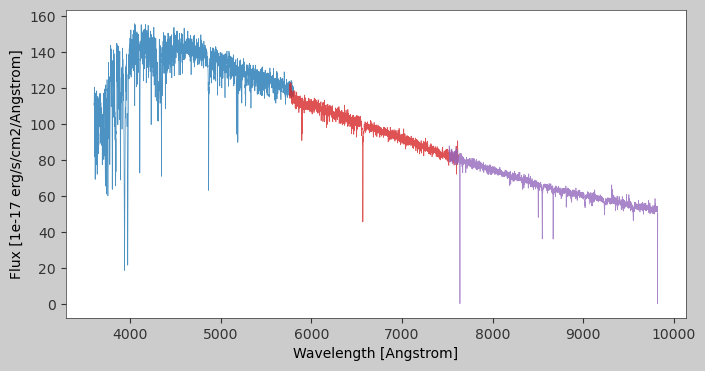

In [12]:
i = np.argmax(coadd.fibermap['FLUX_G'])

plt.figure(figsize=(8,4))
plt.plot(coadd.wave['b'], coadd.flux['b'][i], 'C0', linewidth=0.5, alpha=0.8)
plt.plot(coadd.wave['r'], coadd.flux['r'][i], 'C3', linewidth=0.5, alpha=0.8)
plt.plot(coadd.wave['z'], coadd.flux['z'][i], 'C4', linewidth=0.5, alpha=0.8)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')

targetbits = ' '.join(desi_mask.names(coadd.fibermap['DESI_TARGET'][i]))
targetid = coadd.fibermap['TARGETID'][i]
print(f"TARGETID {targetid} has target bits {targetbits}")

## Other HDUs and Spectra object variables

Now we'll explore some of the other HDUs and how they translate into `Spectra` object variables.

### Inverse Variance (ivar)

`Spectra.ivar` contains the inverse variance of the `.flux`, i.e. 1/error$^2$, from the `B/R/Z_IVAR` HDUs.
`ivar[camera]==0` means infinite error, i.e. bad data that should be excluded from analyses.  Let's replot the
spectrum above while including the error model and excluding bad data.

TARGETID 39627568990655409 has target bits STD_FAINT STD_BRIGHT


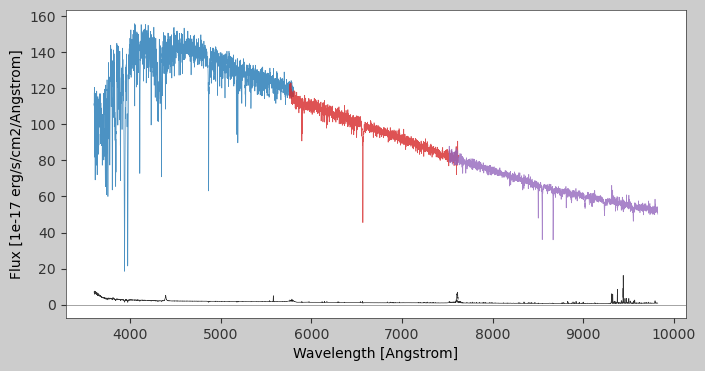

In [13]:
i = np.argmax(coadd.fibermap['FLUX_G'])

cameras = ('b', 'r', 'z')   # same as coadd.bands
colors = ('C0', 'C3', 'C4')

plt.figure(figsize=(8,4))
for camera, color in zip(cameras, colors):
    ok = coadd.ivar[camera][i] > 0
    error = np.sqrt(1/coadd.ivar[camera][i,ok])
    plt.plot(coadd.wave[camera][ok], coadd.flux[camera][i, ok], color, linewidth=0.5, alpha=0.8)
    plt.plot(coadd.wave[camera][ok], error, 'k-', linewidth=0.5, alpha=0.8)

plt.axhline(0, color='0.5', linewidth=0.5)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')

targetbits = ' '.join(desi_mask.names(coadd.fibermap['DESI_TARGET'][i]))
targetid = coadd.fibermap['TARGETID'][i]
print(f"TARGETID {targetid} has target bits {targetbits}")

Note that compared to the previous plot, some of the outliers are gone, while the remainder could be genuine absorption features.
The error model (black) is larger at the edges of the cameras where the throughput is lower, and also larger at the location of sky lines.

#### Exercises

1. Zoom in on individual unmasked outliers.  Do they appear to be real features or unmasked problems?
2. Study the ivar of fainter targets whose noise is dominated by the sky background rather than the shot noise of the object.

### Masks

`spectra.mask[camera]` is an integer bitmask of known issues with the spectra, e.g. pollution from cosmic rays or bad pixels on the CCD.
This comes from the `B/R/Z_MASK` HDUs.
The meaning of each bit is documented in the [mask bits datamodel](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#specmask-bit-definitions), but for most purposes you just need to know that **0 is good**, indicating no known problem.

For spectra and coadd files, the `ivar` has been set to 0 for anywhere that is masked, so filtering by
`.ivar[camera]>0` is equivalent to filtering by `.mask[camera]==0`.

In [14]:
for camera in coadd.bands:
    ivar = coadd.ivar[camera]
    mask = coadd.mask[camera]
    print(f'{camera} camera all masked values have ivar==0:', np.all(ivar[mask>0] == 0.0))

b camera all masked values have ivar==0: True
r camera all masked values have ivar==0: True
z camera all masked values have ivar==0: True


### Spectral Resolution

Compared to prior experiments, a new concept in DESI data is the "Resolution Matrix" which encodes
the per-spectrum wavelength-dependent non-Gaussian instrument resolution, rather than approximating
this as a FWHM or Gaussian sigma.  This is a core output of the "spectroperfectionism" spectral
extraction method used by DESI, following the math formalism of
[Bolton & Schlegel 2012](https://ui.adsabs.harvard.edu/abs/2010PASP..122..248B/abstract),
and described in more detail in [Guy+ 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..144G/abstract)
sections 4.5 and appendix D.

Conceptually, when the resolution matrix "R" is matrix-multiplied by an perfect resolution model spectrum, it produces
the as-observed-by-the-DESI-instrument resolution model, to be compared to the data.

The details are a bit subtle, which we will defer to a dedicated tutorial
[02_digging_deeper/ResolutionMatrix.ipynb](../02_digging_deeper/ResolutionMatrix.ipynb).
As a preview, `coadd[camera].R[i]` contains the band-diagonal matrix resolution model for the `i`th spectrum.
The ResolutionMatrix tutorial shows further details, including how to construct it from the underlying data
format without using DESI-specific code.

For example, let's plot an simple model with a single emission line, and see what the
as-observed resolution output flux would be for two different spectra.

(7520.0, 7536.000000000004)

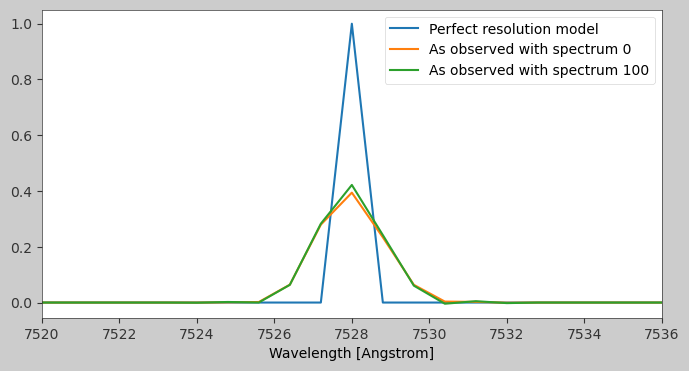

In [15]:
camera = 'z'
model_with_emission_line = np.zeros(len(coadd.wave[camera]))
model_with_emission_line[10] = 1
model_at_observed_resolution_0 = coadd.R[camera][0].dot(model_with_emission_line)
model_at_observed_resolution_1 = coadd.R[camera][100].dot(model_with_emission_line)

wave = coadd.wave[camera]
plt.figure(figsize=(8,4))
plt.plot(wave, model_with_emission_line, label='Perfect resolution model')
plt.plot(wave, model_at_observed_resolution_0, label='As observed with spectrum 0')
plt.plot(wave, model_at_observed_resolution_1, label='As observed with spectrum 100')
plt.xlabel('Wavelength [Angstrom]')
plt.legend()
plt.xlim(wave[0], wave[20])

It's not a big difference, but you can see that the same underlying physical model (blue) has slightly different
output flux depending upon which fiber and exposures observed it (green and orange).

## Manipulating Spectra objects

### Slicing Spectra objects

Spectra object can be sliced, just like slicing an array.  This can be useful to trim down the spectra
to just a subset of objects that you care about for your analysis.

In [16]:
spectra = desispec.io.read_spectra(coaddfile)

lrg_target = spectra.fibermap['DESI_TARGET'] & desi_mask.LRG != 0
qso_target = spectra.fibermap['DESI_TARGET'] & desi_mask.QSO != 0

numLRG = np.sum(lrg_target)
numQSO = np.sum(qso_target)

lrg_spectra = spectra[lrg_target]
qso_spectra = spectra[qso_target]

print(f'{numLRG=} and {len(lrg_spectra)=}')
print(f'{numQSO=} and {len(qso_spectra)=}')

tid1 = np.array(spectra.fibermap['TARGETID'][qso_target])
tid2 = np.array(qso_spectra.fibermap['TARGETID'])
print(f'QSO TARGETIDs are    {tid1[0:5]} ...')
print(f'QSO sliced TARGETIDs {tid2[0:5]} ...')

INFO:spectra.py:391:read_spectra: iotime 0.320 sec to read coadd-main-dark-23040.fits at 2025-03-17T16:03:00.830137
numLRG=337 and len(lrg_spectra)=337
numQSO=228 and len(qso_spectra)=228
QSO TARGETIDs are    [39627568982263324 39627568982262838 39627568982262486 39627568982263659
 39627563017965712] ...
QSO sliced TARGETIDs [39627568982263324 39627568982262838 39627568982262486 39627568982263659
 39627563017965712] ...


### Combining spectra objects

Multiple Spectra objects can be combined together with `desispec.spectra.stack`,
e.g. to combine spectra read+sliced from multiple files into a single Spectrum object.

In [17]:
qsolrg = desispec.spectra.stack([qso_spectra, lrg_spectra])

print(f'{len(qso_spectra)} qso + {len(lrg_spectra)} lrg = {len(qsolrg)} qsolrg')

assert np.all(np.isin(qso_spectra.fibermap['TARGETID'], qsolrg.fibermap['TARGETID']))
assert np.all(np.isin(lrg_spectra.fibermap['TARGETID'], qsolrg.fibermap['TARGETID']))

228 qso + 337 lrg = 565 qsolrg


### Writing spectra objects

Spectra objects can be written with `desispec.io.write_spectra(filename, spectra)`, e.g. to save a file with just the subset of spectra
that you need for an analysis.

In [18]:
if 'SCRATCH' in os.environ:
    outdir = os.path.expandvars('$SCRATCH/desi/temp')
else:
    outdir = os.path.expandvars('$HOME/desi/temp')

os.makedirs(outdir, exist_ok=True)
outfile = outdir+'/qso-spectra.fits'
desispec.io.write_spectra(outfile, qso_spectra)

qso_spectra2 = desispec.io.read_spectra(outfile)
assert len(qso_spectra) == len(qso_spectra2)
assert np.all(qso_spectra.fibermap['TARGETID'] == qso_spectra2.fibermap['TARGETID'])
assert np.all(qso_spectra.flux['b'] == qso_spectra2.flux['b'])

INFO:spectra.py:177:write_spectra: iotime 0.283 sec to write qso-spectra.fits at 2025-03-17T16:03:01.909508
INFO:spectra.py:391:read_spectra: iotime 0.055 sec to read qso-spectra.fits at 2025-03-17T16:03:01.968765


## From catalogs to spectra

A common analysis pattern is to start with a catalog of objects, filter to just the objects of interest,
then read all the spectra for those objects from multiple input files.
That can be accomplished with the tools above (read + slice + stack), but is simplified by using
`desispec.io.read_spectra_parallel` to interpret a table of targets, derive what files need to be read,
read those files and filter to just the targets requested, and then stack the results together.
This has the additional benefit of using parallelism to read multiple input files simultaneously.

In [19]:
desispec.io.read_spectra_parallel?

Signature:
desispec.io.read_spectra_parallel(
    targets,
    nproc=None,
    prefix='coadd',
    rdspec_kwargs={},
    specprod=None,
    match_order=True,
    comm=None,
)
Docstring:
Read spectra for targets table in parallel

Args:
    targets (table): targets table; see notes for required columns

Options
    nproc (int): number of processes to use if comm is None
    prefix (str): 'coadd' or 'spectra'
    rdspec_kwargs (dict): additional key/value args to pass to read_spectra
    specprod (str): production name or full path to production
    match_order (bool): if True (default), spectra will match order of input targets
    comm: MPI communicator

Returns: Spectra for targets in targets table

If comm is not None, use MPI, elif nproc>1 use multiprocessing, else read
serially but still read each file only once to get the necessary targets.

If targets table has columns TARGETID,TILEID,LASTNIGHT,PETAL_LOC,
then specta will be read from tiles/cumulative files.  Otherwise,
if target

Older versions of `desispec.io.read_spectra_parallel` requires `$DESI_SPECTRO_REDUX` to be set for it to know
where to find the spectroscopic reductions on disk, so we'll also set that here if needed for backwards compatibility.
NERSC environments already have this set.

In [20]:
if 'DESI_SPECTRO_REDUX' not in os.environ:
    os.environ['DESI_SPECTRO_REDUX'] = os.path.expandvars('$DESI_ROOT/spectro/redux')
    print('Set $DESI_SPECTRO_REDUX={}'.format(os.environ['DESI_SPECTRO_REDUX']))

Set $DESI_SPECTRO_REDUX=/Users/sbailey/desi/tiny_dr1//spectro/redux


For example, let's read a redshift catalog, filter it to just high-z QSOs, and use `read_spectra_parallel` to read the corresponding spectra.

In [21]:
#- read the redshift catalog (slow, can take 30-60 seconds)
zcatfile = f'{specprod_dir}/zcatalog/v1/zall-pix-{specprod}.fits'
columns = ('TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'SPECTYPE', 'Z', 'ZWARN', 'DELTACHI2')
zcat = fitsio.read(zcatfile, 'ZCATALOG', columns=columns)

In [22]:
keep = zcat['SPECTYPE'] == 'QSO'
keep &= zcat['Z'] > 2.5
keep &= zcat['ZWARN'] == 0

#- restrict to just the healpix included in the tiny_dr1 subset;
#- at NERSC or elsewhere with the full DR1 dataset, this isn't necessary
keep &= zcat['HEALPIX'] == 23040

In [23]:
#- Table of targets to read, with a cap of 1000 targets so that we don't use a ton of memory
zcat_to_read = zcat[keep][0:1000]

In [24]:
print(f'Reading {len(zcat_to_read)} targets')
spectra = desispec.io.read_spectra_parallel(zcat_to_read, specprod=specprod)
print(f'{len(spectra)=}')

Reading 35 targets
INFO:spectra.py:391:read_spectra: iotime 0.181 sec to read coadd-main-dark-23040.fits at 2025-03-17T16:03:20.576123
len(spectra)=35


Note that in this case, we had already filtered to a single healpix and thus it only read one file, but in general
it can read multiple input files and filter+stack the spectra for you.

Text(0.5, 1.0, '5 DESI high-redshift quasars')

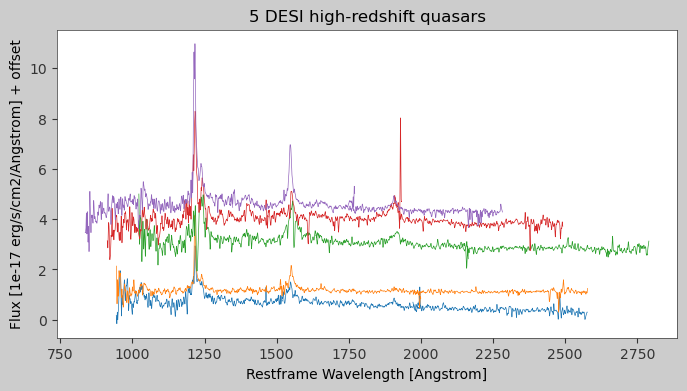

In [25]:
#- Plot the first 5 QSOs in restframe, with smoothing for visualization
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(8,4))
nspec = 5
for i, z in enumerate(zcat_to_read['Z'][0:nspec]):
    for camera in spectra.bands:
        restwave = spectra.wave[camera] / (1+z)
        flux = gaussian_filter1d(spectra.flux[camera][i], 5)
        plt.plot(restwave, flux+ i, color=f'C{i}', linewidth=0.5)

plt.xlabel('Restframe Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom] + offset')
plt.title(f'{nspec} DESI high-redshift quasars')

## Reading spectra efficiently

By default, `desispec.io.read_spectra` reads all HDUs and all columns of all tables.
If you know that you won't be using certain HDUs or columns, you can save I/O time and memory
by excluding those:
  * `read_spectra(filename, skip_hdus=...)`: provide list of HDUs to skip, without the `B/R/Z_` prefix
    * **NOTE**: wavelength, flux, and ivar are required and will always be read
  * `read_spectra(filename, select_columns=dict(FIBERMAP=...,))`: provide list of fibermap columns to read (can also provide lists of columns for `EXP_FIBERMAP` and `SCORES`).

Additionally, the data on disk are kept as 32-bit floats (single-precision), but automatically promoted
to 64-bit floats (double-precision) for calculations.  If you don't need that precision, you can save
memory and conversion time by specifying `read_spectra(filename, single=True)`.

For example, reading just the wavelength and flux arrays as single-precision, and a few fibermap columns:

In [26]:
print('Reading everything')
spectra = desispec.io.read_spectra(coaddfile)

print('Reading a subset of the HDUs')
spectra = desispec.io.read_spectra(coaddfile, single=True,
                                   skip_hdus=['RESOLUTION', 'MASK', 'EXP_FIBERMAP', 'SCORES'],
                                   select_columns=dict(FIBERMAP=['TARGETID', 'TARGET_RA', 'TARGET_DEC']))

Reading everything
INFO:spectra.py:391:read_spectra: iotime 0.228 sec to read coadd-main-dark-23040.fits at 2025-03-17T16:03:21.022984
Reading a subset of the HDUs
INFO:spectra.py:391:read_spectra: iotime 0.026 sec to read coadd-main-dark-23040.fits at 2025-03-17T16:03:21.235238


Reading just the subset of data was ~10x faster, and the output contains only the data of interest

In [27]:
print(f'spectra.wave exists: {spectra.wave is not None}')
print(f'spectra.flux exists: {spectra.flux is not None}')
print(f'spectra.ivar exists: {spectra.ivar is not None}')
print(f'{spectra.fibermap.colnames=}')
print(f'{spectra.mask=}')
print(f'{spectra.exp_fibermap=}')
print(f'{spectra.scores=}')

spectra.wave exists: True
spectra.flux exists: True
spectra.ivar exists: True
spectra.fibermap.colnames=['TARGETID', 'TARGET_RA', 'TARGET_DEC']
spectra.mask=None
spectra.exp_fibermap=None
spectra.scores=None


## Coadding across cameras

DESI spectra keep the individual cameras b,r,z separate to enable detailed analyses that need to
fit the cameras separately, e.g. due to differing resolutions in the wavelength overlap region.
If that level of detail is not needed, the data can be combined across cameras using `desispec.coaddition.coadd_cameras`.

In [28]:
camcoadd = coadd_cameras(coadd)
print(f"original bands: {coadd.bands}")
print(f"camcoadd bands: {camcoadd.bands}")

original bands: ['b', 'r', 'z']
camcoadd bands: ['brz']


Text(0.5, 0, 'Wavelength [Angstrom]')

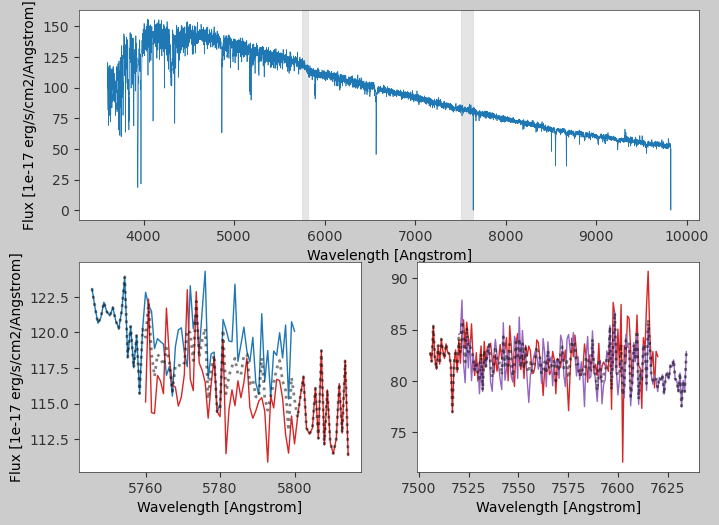

In [29]:
i = np.argmax(coadd.fibermap['FLUX_G'])

wavepad = 15
wavemin_br = np.min(coadd.wave['r']) - wavepad
wavemax_br = np.max(coadd.wave['b']) + wavepad

wavemin_rz = np.min(coadd.wave['z']) - wavepad
wavemax_rz = np.max(coadd.wave['r']) + wavepad

#- Plot the full spectrum
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(camcoadd.wave['brz'], camcoadd.flux['brz'][i], linewidth=0.5)
plt.axvspan(wavemin_br, wavemax_br, color='k', alpha=0.1)
plt.axvspan(wavemin_rz, wavemax_rz, color='k', alpha=0.1)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')

#- Plot just the overlap between b and r
plt.subplot(223)

#- plot the original per-camera spectra
ww = (wavemin_br < coadd.wave['b']) & (coadd.wave['b'] < wavemax_br)
plt.plot(coadd.wave['b'][ww], coadd.flux['b'][i, ww], 'C0', linewidth=1)
ww = (wavemin_br < coadd.wave['r']) & (coadd.wave['r'] < wavemax_br)
plt.plot(coadd.wave['r'][ww], coadd.flux['r'][i, ww], 'C3', linewidth=1)

#- plot the spectra combined across cameras
ww = (wavemin_br < camcoadd.wave['brz']) & (camcoadd.wave['brz'] < wavemax_br)
plt.plot(camcoadd.wave['brz'][ww], camcoadd.flux['brz'][i, ww], 'k:', linewidth=2, alpha=0.5)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')

#- Plot just the overlap between r and z
plt.subplot(224)

#- plot the original per-camera spectra
ww = (wavemin_rz < coadd.wave['r']) & (coadd.wave['r'] < wavemax_rz)
plt.plot(coadd.wave['r'][ww], coadd.flux['r'][i, ww], 'C3', linewidth=1)
ww = (wavemin_rz < coadd.wave['z']) & (coadd.wave['z'] < wavemax_rz)
plt.plot(coadd.wave['z'][ww], coadd.flux['z'][i, ww], 'C4', linewidth=1)

#- plot the spectra combined across cameras
ww = (wavemin_rz < camcoadd.wave['brz']) & (camcoadd.wave['brz'] < wavemax_rz)
plt.plot(camcoadd.wave['brz'][ww], camcoadd.flux['brz'][i, ww], 'k:', linewidth=2, alpha=0.5)
plt.xlabel('Wavelength [Angstrom]')
# plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')


Where the cameras don't overlap in wavelength, the camcoadd spectrum (dotted) is the same as the individual
spectra (colors).
Where they overlap, the camcoadd is a weighted average of the individual cameras.
This is a case where there is good consistency between the `r` and `z` cameras (right) but a possible
small flux mis-calibration between the `b` and `r` cameras (left).  An analysis of just the
camera-coadded data might mis-interpret this, while a per-camera analysis could absorb that
offset as a nuisance term in the fit.

#### Exercise

Study the `b` vs. `r` and `r` vs. `z` consistency for other spectra.  Is this level of offset normal or unusual for DESI spectra?

## Tile-based spectra

The above emphasized healpix-grouped spectra, since we expect that most analyses will use those
to gain the benefits of higher S/N from coadding across tiles observed under the same survey and program.
However, there are case where analyses would prefer to use tile-based spectra.  These include:
* SURVEY=special tiles are designed for a custom purpose with different targets than the main survey.
  Using just the spectra from the tiles of interest avoid the overhead of reading and discarding
  spectra from other projects that happened to overlap the same location.
* The DESI Large Scale Structure (LSS) catalogs are generated from tile-based spectra to simplify
  the bookkeeping of the probability that each target would be observed at a given time.
* If an analysis is sensitive to systematics that may vary with focal plane location or location
  of the spectrum on individual spectrograph CCDs, that is cleanly separated in the tile-based
  spectra while the healpix-based spectra coadds from different locations.

As a review from [03_DataOrganization.ipynb](03_DataOrganization.ipynb), tile-based spectra are under `spectro/redux/iron/tiles/cumulative/TILEID/LASTNIGHT/`, where
  * "iron" is the primary spectroscopic production name in DR1
  * "cumulative" refers to coadding the all data for that tile
    * NOTE: SURVEY=sv1 data have many observations over multiple nights of the same tiles; these also have a "pernight" version that coadds data within a night but not across night; this can be used to compare redshift success and other algorithm performance on typical S/N data (pernight) vs. the higher S/N (cumulative) data
  * TILEID is the integer tile idetification number from the redshift catalog
  * LASTNIGHT is the YEARMMDD date of the last night that this tile was observed.

Within each directory, data are split by focal plane petal (0-9), with 500 spectra per file.  For example:

In [30]:
path = f'{specprod_dir}/tiles/cumulative'
for depth in range(3):
    contents = os.listdir(path)
    print(f'Contents of {path}:')
    if len(contents) < 20:
        content_str = ' '.join(contents)
    else:
         content_str = ' '.join(contents[0:20]) + ' ...'
    print(content_str)
    path = os.path.join(path, contents[0])

Contents of /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/tiles/cumulative:
10256 2436 5568
Contents of /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/tiles/cumulative/10256:
20211110
Contents of /Users/sbailey/desi/tiny_dr1//spectro/redux/iron/tiles/cumulative/10256/20211110:
qso_mgii-3-10256-thru20211110.fits rrdetails-4-10256-thru20211110.h5 redrock-2-10256-thru20211110.fits spectra-0-10256-thru20211110.fits.gz coadd-0-10256-thru20211110.fits zmtl-2-10256-thru20211110.fits emline-2-10256-thru20211110.fits qso_qn-2-10256-thru20211110.fits qso_mgii-8-10256-thru20211110.fits redrock-6-10256-thru20211110.fits coadd-4-10256-thru20211110.fits rrdetails-6-10256-thru20211110.h5 redrock-9-10256-thru20211110.fits qso_mgii-7-10256-thru20211110.fits qso_qn-6-10256-thru20211110.fits zmtl-9-10256-thru20211110.fits emline-9-10256-thru20211110.fits spectra-7-10256-thru20211110.fits.gz emline-6-10256-thru20211110.fits zmtl-6-10256-thru20211110.fits ...


## Summary

* DESI spectra are grouped either by healpix location on the sky, or grouped per tile.
* Most analyses can use the healpix-based spectra under `$DESI_ROOT/spectro/redux/iron/healpix/SURVEY/PROGRAM/HPIXGROUP/HEALPIX/`
* Most analyses can use the coadded spectra in `coadd-SURVEY-PROGRAM-HEALPIX.fits`
* `desispec.io.read_spectra` returns a `desispec.spectra.Spectra` object that makes working with these spectra easier.
* `desispec.coaddition.coadd_cameras` can coadd across cameras for convenience, though beware of possible systematics at camera boundaries.